## News Feature

From the previously saved dataframe, a numerical news feature is calculated, describing potential impact.

#### Principle: 

- The closer the news release in time, the more the potential impact
- News releases within a two hours window are taken into account
- News have different impacts: i.e. Central bank interest rate vs industrial production

Calculating the news feature, according to the formula below:

$ News_{t} = \sum_{t_n-t}^{t+t_n} e^\frac{-|t_n-t|}{\tau}\times IF_n$

Where:

- $t_n$ is the time of news release
- $IF_n$ is the impact for the news n
- news n belong to a window of +/- 2 hours relative to t

In [2]:
import datetime
import pandas as pd
import numpy as np
import math as m 

from numpy import timedelta64
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline

import sys 
import warnings
warnings.filterwarnings("ignore")

#### Constants

In [3]:
LowImpact = 0.25
MediumImpact = 0.5
HighImpact = 1

Deciding on an arbitrary $\tau$, so that the impact of news is pretty much 0 beyond two hours

In [4]:
Tau = 30 # 36% in 90 minutes away from the piece of news / 50% 60 minutes away

In [5]:
df = pd.read_csv('./EconomicalNews.csv',index_col=0)

In [6]:
df.Datetime = pd.to_datetime(df.Datetime)
df.set_index('Datetime', inplace = True)

In [7]:
startD = df.head(1).index[0]
endD = df.tail(1).index[0]

Calculating for USD

In [8]:
df.reset_index(inplace = True)
du = df[df['Currency'] == 'USD']
# Getting rid of event that happen at the same time with the same Impact. 
# It is not perfect but the description didn't seem good enough to remove duplicates.
du.drop_duplicates(subset=['Datetime','Impact'],inplace= True)

In [9]:
du[du['Datetime'] >= datetime(2019,10,30)].head()

,Datetime,Currency,Event,Actual,Forecast,Previous,Impact
32,2019-10-30 08:15:00,USD,ADP Non-Farm Employment Change,125K,125K,93K,High Impact Expected
33,2019-10-30 08:30:00,USD,Advance GDP q/q,1.9%,1.6%,2.0%,High Impact Expected
34,2019-10-30 08:30:00,USD,Advance GDP Price Index q/q,1.7%,1.8%,2.4%,Medium Impact Expected
38,2019-10-30 10:30:00,USD,Crude Oil Inventories,5.7M,0.5M,-1.7M,Medium Impact Expected
40,2019-10-30 14:00:00,USD,FOMC Statement,NaN,NaN,NaN,High Impact Expected


Adding the numerical impact colunmn based on constants

In [10]:
conditions = [du['Impact']=='High Impact Expected', du['Impact']=='Medium Impact Expected', du['Impact']=='Low Impact Expected']
values = [1.0,0.75,0.25]
du['IndImpact'] = np.select(conditions, values, default = -1)
du[['Event', 'Impact','IndImpact']].head()

,Event,Impact,IndImpact
4,Goods Trade Balance,Low Impact Expected,0.25
15,S&P/CS Composite-20 HPI y/y,Low Impact Expected,0.25
16,CB Consumer Confidence,High Impact Expected,1.00
17,Pending Home Sales m/m,Low Impact Expected,0.25
32,ADP Non-Farm Employment Change,High Impact Expected,1.00


For this example, it will be calculated between for October 30th 2019, between 5.15am and 4pm

In [11]:
startDate = datetime(2019,10,30, 5, 15, 0)
stopDate = datetime(2019,10,30, 16, 0, 0)
delta = stopDate - startDate

In [12]:
Newsn = []

for minutes in range(0,int(delta.seconds/60+1)):
    currentDtime = startDate + timedelta(minutes = minutes)
    
    # Getting the events in the past
    dpast = du[(du['Datetime'] >= (currentDtime - timedelta(hours=2))) & (du['Datetime'] <= (currentDtime ))]
    # Getting the events in the future
    # Past "<=" CurrentDtime / Future ">" currentDtime to avoid having an event in both future and past 
    dfuture = du[(du['Datetime'] > (currentDtime)) & (du['Datetime'] <= (currentDtime + timedelta(hours=2)))]
    
    # If there is no event in the past Tpast = 0
    if (dpast.shape[0]>0):
        
        # Calculating time passed until the event
        dpast['TimeToEvent'] = ((currentDtime) - du['Datetime']).astype(timedelta64)*1e-9/60
        # Calculating  EXP( -TimeToEvent / Tau)

        dpast['exp'] =  dpast['TimeToEvent'].apply(lambda x: m.exp(-x/Tau))
        # Scaling accoring to news importance
        dpast['Sc_exp'] = dpast['exp'] * dpast['IndImpact']

        # Calculating the contribution due to the past events
        Tpast = dpast['Sc_exp'].sum()
    else: Tpast = 0

    
    if(dfuture.shape[0]>0 ):
        # Calculating time left until the event
        dfuture['TimeToEvent'] = (du['Datetime'] - (currentDtime)).astype(timedelta64)*1e-9/60
        # Calculating  EXP( -TimeToEvent / Tau)
        dfuture['exp'] =  dfuture['TimeToEvent'].apply(lambda x: m.exp(-x/Tau))
        # Scaling accoring to news importance
        dfuture['Sc_exp'] = dfuture['exp'] * dfuture['IndImpact']

        # Calculating the contribution due to the future events
        Tfut = dfuture['Sc_exp'].sum()
    else: Tfut = 0

    Newsn.append(Tpast+Tfut)

Ploting the resulting feature and the news dataframe for the considered period

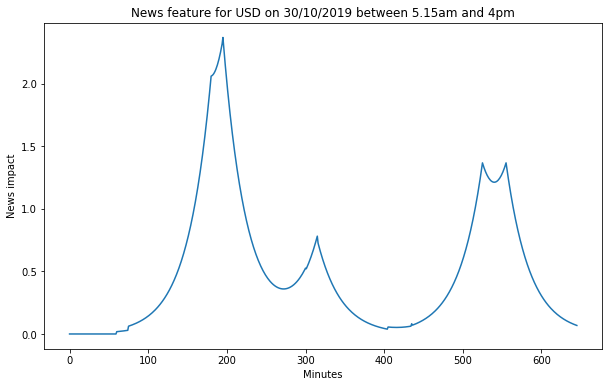

In [13]:
plt.figure(figsize=(10,6))
plt.plot(Newsn)
plt.title('News feature for USD on 30/10/2019 between 5.15am and 4pm')
plt.xlabel('Minutes')
plt.ylabel('News impact')
plt.show()

In [15]:
du[(du['Datetime'] >= (startDate - timedelta(hours=2))) & (du['Datetime'] <= (startDate  + timedelta(hours=20)))]

,Datetime,Currency,Event,Actual,Forecast,Previous,Impact,IndImpact
32,2019-10-30 08:15:00,USD,ADP Non-Farm Employment Change,125K,125K,93K,High Impact Expected,1.00
33,2019-10-30 08:30:00,USD,Advance GDP q/q,1.9%,1.6%,2.0%,High Impact Expected,1.00
34,2019-10-30 08:30:00,USD,Advance GDP Price Index q/q,1.7%,1.8%,2.4%,Medium Impact Expected,0.75
38,2019-10-30 10:30:00,USD,Crude Oil Inventories,5.7M,0.5M,-1.7M,Medium Impact Expected,0.75
40,2019-10-30 14:00:00,USD,FOMC Statement,NaN,NaN,NaN,High Impact Expected,1.00
42,2019-10-30 14:30:00,USD,FOMC Press Conference,NaN,NaN,NaN,High Impact Expected,1.00
